In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import math
import time
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from scipy.stats import norm

from sklearn.ensemble import RandomForestRegressor   
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from SimulatedAnnealing import SimulatedAny
from BayersOptimlization import Bayes_Optimalizator

from sklearn.gaussian_process import GaussianProcessRegressor

## Loading the data + preprocessing

In [3]:
pd_data = pd.read_csv('boston.csv')

Piece of dataset

In [4]:
pd_data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


In [4]:
pd_data.info() # seems like there are no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


Histograms

array([[<AxesSubplot:title={'center':'CRIM'}>,
        <AxesSubplot:title={'center':'ZN'}>,
        <AxesSubplot:title={'center':'INDUS'}>,
        <AxesSubplot:title={'center':'CHAS'}>],
       [<AxesSubplot:title={'center':'NOX'}>,
        <AxesSubplot:title={'center':'RM'}>,
        <AxesSubplot:title={'center':'AGE'}>,
        <AxesSubplot:title={'center':'DIS'}>],
       [<AxesSubplot:title={'center':'RAD'}>,
        <AxesSubplot:title={'center':'TAX'}>,
        <AxesSubplot:title={'center':'PTRATIO'}>,
        <AxesSubplot:title={'center':'B'}>],
       [<AxesSubplot:title={'center':'LSTAT'}>,
        <AxesSubplot:title={'center':'MEDV'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

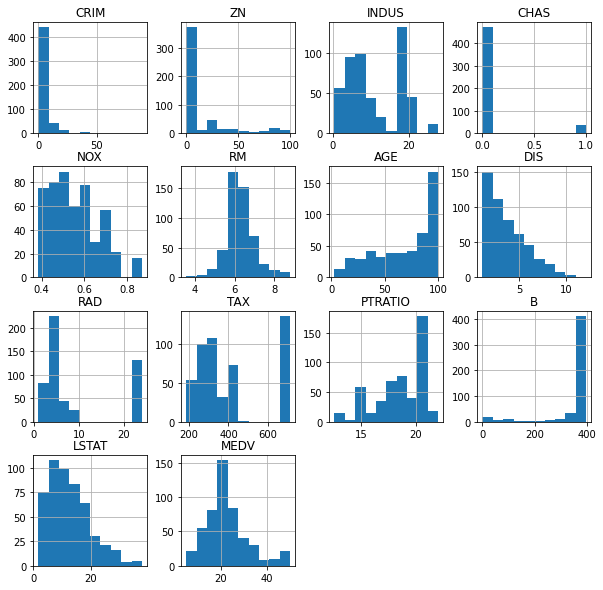

In [5]:
pd_data.hist(figsize=(10,10)) # visualising the distrbution of data

## Corelation matrix (Heatmap can be found in TPOT notebook)

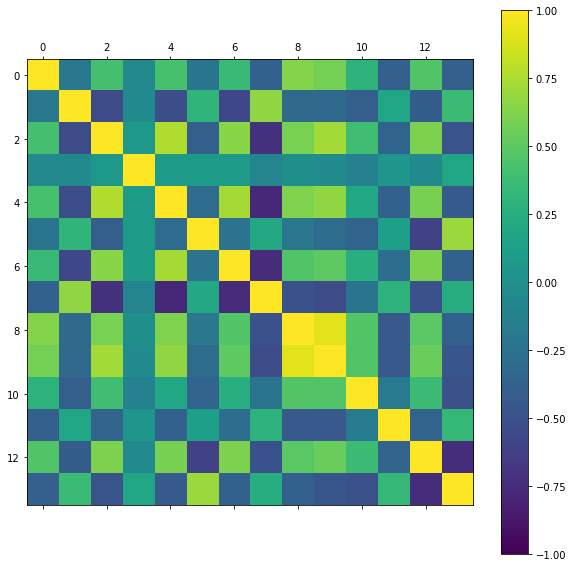

In [6]:
correlations = pd_data.corr()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

## Split to train X and Y

In [7]:
X = pd_data[pd_data.columns[1:-2]]
Y = pd.DataFrame(pd_data[pd_data.columns[-1]])

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.75, test_size=0.25, random_state=42)

scaler_X = StandardScaler()

scaler_X.fit(X_train)


Train_scaled_X = scaler_X.transform(X_train)

Test_scaled_X = scaler_X.transform(X_test)


# MODELS

## Parameter ranges

In [8]:
SVR_parameters_ranges = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 
                         'C': [0.00001,0.0001,0.001,0.01,0.1,1], 'gamma': ['scale','auto']}

RFR_parameters_ranges = {'max_depth': np.arange(1,250), 'n_estimators': np.arange(1,250), 
                    'criterion': ['mae','mse'], 'max_features' : ["sqrt","log2"]}

KNNR_parameters_ranges = {'n_neighbors':np.arange(1,50), 'weights' : ['uniform', 'distance'], 
                          'algorithm': ['ball_tree', 'kd_tree', 'brute'],'leaf_size': np.arange(1,50),
                         'metric' : ['euclidean', 'manhattan', 'minkowski']}

### Objective functions

In [9]:
def objective_function_random_forest(parameters,pd_train_data_X, pd_train_data_Y):

    Forest_regre = RandomForestRegressor(**parameters, random_state=0)
    scores = cross_val_score(Forest_regre, pd_train_data_X, pd_train_data_Y.values.ravel(), cv=5,scoring='neg_root_mean_squared_error')
    return scores.mean()

def objective_function_SVC(parameters,pd_train_data_X, pd_train_data_Y):
    sv = SVR(**parameters)
    scores = cross_val_score(sv, pd_train_data_X, pd_train_data_Y.values.ravel(), cv=5,scoring='neg_root_mean_squared_error')
    return scores.mean()

def objective_function_KNN(parameters,pd_train_data_X, pd_train_data_Y):
    knn_clas = KNeighborsRegressor(**parameters)
    scores = cross_val_score(knn_clas, pd_train_data_X, pd_train_data_Y.values.ravel(), cv=5,scoring='neg_root_mean_squared_error')
    return scores.mean()


### Bayesian optimalization extra 

In [10]:
def acquisition_Function(random_param,real_X,real_Y,surrogate):
    #get the best parameters so far
    score_pred = surrogate.predict(real_X)
    best = max(real_Y)

            
    #predict accurcy 
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        mu, std = surrogate.predict(random_param, return_std=True)
  
        mu = mu[:, 0]
    
        probs = norm.cdf((mu - best) / (std))
    
    ix = np.argmax(probs)
    
    return random_param[ix]

pr_model = GaussianProcessRegressor(random_state=0)

## Optimalization

In [11]:
best_candidates_SA = []
best_scores_SA = []
best_metro_SA = []
times_SA = []

best_SA = []

best_candidates_Bay = []
best_score_Bay = []
times_Bay = []

best_Bay = []


In [ ]:
for callss in range(20):
    SAs = [SimulatedAny(objective_function_random_forest,RFR_parameters_ranges),
       SimulatedAny(objective_function_SVC, SVR_parameters_ranges),
       SimulatedAny(objective_function_KNN,KNNR_parameters_ranges)]

    Bays = [Bayes_Optimalizator(objective_function_random_forest,pr_model,acquisition_Function,RFR_parameters_ranges),
            Bayes_Optimalizator(objective_function_SVC,pr_model,acquisition_Function,SVR_parameters_ranges),
            Bayes_Optimalizator(objective_function_KNN,pr_model,acquisition_Function,KNNR_parameters_ranges)]
    

    ids = 1

    for id_x,x in enumerate(SAs):
        st_time = time.time()
        scor,candi,metro = x.run(1000,5,100,Train_scaled_X,y_train)
        so_time = time.time()

        all_t = so_time - st_time
        times_SA.append(all_t)

        best_candidates_SA.append(candi[-1])
        best_SA.append(scor[-1])
        best_scores_SA.append(scor)
        best_metro_SA.append(metro)

        plt.figure()
        plt.plot(best_scores_SA[-1])
        plt.xlabel('Iterations')
        plt.ylabel('n-RMSe')
        plt.grid()
        mod = ['SA - forest','SA-SVR','SA-KNN']
        plt.title('{}'.format(mod[id_x]))
        plt.savefig('{}-call_{}.Model_{}_score={}.png'.format(callss,ids,mod[id_x],best_SA[-1]))
        ids += 1




    for id_x,x in enumerate(Bays):
        st_time = time.time()
        score,par,best = x.optimaze(1000,Train_scaled_X,y_train)
        so_time = time.time()

        all_t = so_time - st_time
        times_Bay.append(all_t)

        best_candidates_Bay.append(par[-1])
        best_score_Bay.append(best)    

        best_Bay.append(best[-1])

        plt.figure()
        plt.plot(best_score_Bay[-1])
        plt.xlabel('Iterations')
        plt.ylabel('n-RMSe')
        plt.grid()
        mod = ['BA - forest','BA-SVR','BA-KNN']
        plt.title('{}'.format(mod[id_x]))
        plt.savefig('{}-call_{}.Model_{}_score={}.png'.format(callss,ids,mod[id_x],best_Bay[-1]))
        ids += 1            



## Evaluation

In [ ]:
select_SA_BEST = np.argmax(best_SA)
select_BA_BEST = np.argmax(best_Bay)

model = 0
param = 0

if best_SA[select_SA_BEST] > best_Bay[select_BA_BEST]:
    model = select_SA_BEST
    param = best_candidates_SA[select_SA_BEST]
else:
    model = select_BA_BEST
    param =  best_candidates_Bay[select_BA_BEST]

In [15]:
def evaluate_best(id_mod, pd_train_X,pd_train_Y,pd_test_X,pd_test_Y,parameters):
    if id_mod == 0:
        model = RandomForestRegressor(**parameters, random_state=0)
    elif id_mod == 1:
        model = SVR(**parameters)
    elif id_mod == 2:
        model =KNeighborsRegressor(**parameters)
        
    res = model.fit(pd_train_X,pd_train_Y.values.ravel())
    
    pred = res.predict(pd_test_X)
    
    return -np.sqrt(mean_squared_error(pd_test_Y.values.ravel(),pred))

In [16]:
print(evaluate_best(model,Train_scaled_X,y_train,Test_scaled_X,y_test,param))